# Homework 3: Predicting MegaTelCo Churn
---
**Summer 2025 - Intructor: Joyce Yang**

**Adapted from teaching materials by Prof. Chris Volinksy Fall 2024.**

After discussing the churn problem at TelCo with Nadia for a while (remember her?), you've finally defined an adequate target variable for churn and gathered relevant data to predict it. Moreover, the marketing department has come up with an amazing retention offer: the offer is guaranteed to convince customers to extend their contract for an extra year after receiving it. Unfortunately, the offer is quite expensive; it costs $200. __You have enough budget to give the retention offer to up to 25% of the customers whose contracts are expiring.__

It is your job to use data from previous contract expirations to build a churn predictive model and make a recommendation of whom to target with the offers. You have assembled the best historical data set you can at this point, which includes:

- Gender: Whether the customer is a male or a female
- SeniorCitizen: Whether the customer is a senior citizen or not (1, 0)
- Partner: Whether the customer has a partner or not (Yes, No)
- Dependents: Whether the customer has dependents or not (Yes, No)
- Tenure: Number of months the customer has stayed with the company
- PhoneService: Whether the customer has a phone service or not (Yes, No)
- MultipleLines: Whether the customer has multiple lines or not (Yes, No, No phone service)
- InternetService: Customer’s internet service provider (DSL, Fiber optic, No)
- OnlineSecurity: Whether the customer has online security or not (Yes, No, No internet service)
- OnlineBackup: Whether the customer has online backup or not (Yes, No, No internet service)
- DeviceProtection: Whether the customer has device protection or not (Yes, No, No internet service)
- TechSupport: Whether the customer has tech support or not (Yes, No, No internet service)
- StreamingTV: Whether the customer has streaming TV or not (Yes, No, No internet service)
- StreamingMovies: Whether the customer has streaming movies or not (Yes, No, No internet service)
- Contract: The contract term of the customer (Month-to-month, One year, Two year)
- PaperlessBilling: Whether the customer has paperless billing or not (Yes, No)
- PaymentMethod: The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
- MonthlyCharges: The amount charged to the customer monthly
- Churn: Whether the customer churned or not shortly after contract expiration (Yes or No)

In [4]:
#load important packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
!pip install dmba
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV


**1. Load the churn data [click here to download data](https://drive.google.com/uc?download&id=1xMMPIFOooEzcrdDFNFYvId5aROmTuzxv):**

**Use `get_dummies` to transform the categorical features into dummy features.**

In [5]:
#upload file
from google.colab import files
uploaded = files.upload()

Saving telco_churn.csv to telco_churn (1).csv


In [6]:
data = "telco_churn.csv"
df = pd.read_csv(data)
print(df.describe())
print(df.columns)
#list of categorical columns
categorical_columns = [
    'gender',
    'Partner',
    'Dependents',
    'PhoneService',
    'MultipleLines',
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'Contract',
    'PaperlessBilling',
    'PaymentMethod',
    'Churn'
]

# Apply get_dummies
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

print(df_encoded.head())


       SeniorCitizen       tenure  MonthlyCharges
count    7032.000000  7032.000000     7032.000000
mean        0.162400    32.421786       64.798208
std         0.368844    24.545260       30.085974
min         0.000000     1.000000       18.250000
25%         0.000000     9.000000       35.587500
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.862500
max         1.000000    72.000000      118.750000
Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'Churn'],
      dtype='object')
   SeniorCitizen  tenure  MonthlyCharges  gender_Male  Partner_Yes  \
0              0       1           29.85        False         True   
1              0      34           56.95         True      

__2. _Of course_ normally we would do some detailed exploratory work!  But we have high confidence in the data quality and there are no missing values, so lets proceed.__

__Define X and y and split your data into Training and Test using an 80/20 split (setting a `random_state=13`)__

In [26]:
X = df_encoded.drop(columns=['Churn_Yes'])
y = df_encoded['Churn_Yes']
#train model
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=13
)
print("X_Train ", X_train, "X_Test ",X_test, "y_train ", y_train, "y_test ", y_test)


X_Train        SeniorCitizen  tenure  MonthlyCharges  gender_Male  Partner_Yes  \
1279              0      72          105.50        False         True   
4459              0      48           69.55        False         True   
2183              0      29           31.20        False        False   
7016              0      13           73.35         True        False   
6873              0       3           35.15         True         True   
...             ...     ...             ...          ...          ...   
866               0      59           85.55         True         True   
2790              1       9           74.55        False        False   
74                0       3           64.50        False        False   
6320              0      46          104.40        False        False   
338               0      36           94.80        False        False   

      Dependents_Yes  PhoneService_Yes  MultipleLines_No phone service  \
1279           False              True  

__3. Build the best model you can on the TRAINING set using a decision tree classifier.  We will do a grid search over the hyperparameters `max_depth` and `min_samples_leaf`.  Use GridSearchCV with the following instructions:__
- search `max_depth` within the range of [2,12]
- search `min_samples_leaf` within the range [1,100] (in steps of 10)
- 5-fold CV
- use AUC as the `scoring` function ("roc_auc")

**Report the optimal values of the parameters `min_samples_leaf` and `max_depth` and the AUC associated with it. Please state your logic of picking optimal values of the parameters.**

**Define a model `tree_best` that uses your optimized value of `min_samples_leaf` and `max_depth` and fit it to the 80% training data.**

In [8]:
##setting up model
param_grid = {
    'max_depth': list(range(2, 13)),
    'min_samples_leaf': list(range(1, 101, 10))
}
tree = DecisionTreeClassifier(random_state=13)
#hyperparameter tuning
grid_search = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
best_max_depth = grid_search.best_params_['max_depth']
best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']
best_auc = grid_search.best_score_

print("Best hyperparameters:")
print("  max_depth:", best_max_depth)
print("  min_samples_leaf:", best_min_samples_leaf)
print(f"Best AUC from 5-fold CV: {best_auc:.4f}")

#finding best tree
tree_best = DecisionTreeClassifier(
    max_depth=best_max_depth,
    min_samples_leaf=best_min_samples_leaf,
    random_state=13
)

tree_best.fit(X_train, y_train)

Best hyperparameters:
  max_depth: 7
  min_samples_leaf: 81
Best AUC from 5-fold CV: 0.8281


DecisionTreeClassifier(max_depth=7, min_samples_leaf=81, random_state=13)

**4. Calculate the feature importances.  For the top 5 most important features, explain whether you think they would be positively or negatively correlated with churn.**

In [9]:
importances = tree_best.feature_importances_
# Match with column names
feature_names = X_train.columns
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Display top 5
top5 = feat_imp_df.head(5)
print(top5)

                            Feature  Importance
1                            tenure    0.481237
9       InternetService_Fiber optic    0.347392
2                    MonthlyCharges    0.049366
17  TechSupport_No internet service    0.027939
27   PaymentMethod_Electronic check    0.021447


**5.  Now fit Logistic Regression using Lasso regularization. Test the following values of the shrinkage hyperparameter C:  `C=[0.01,.1,1,10,100]`, and report on which value of C results in the highest AUC. Define a model `lr_best` that uses the best value of C.**


In [10]:
C_values = [0.01, 0.1, 1, 10, 100]
results = {}

for C in C_values:
    lr = LogisticRegression(penalty='l1',solver='liblinear',C=C,random_state=13,
      max_iter=1000
    )
    lr.fit(X_train, y_train)

    y_proba = lr.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)

    results[C] = auc
    print(f"C = {C:<6} --> AUC = {auc:.4f}")
    # Get best C value
best_C = max(results, key=results.get)
print(f"\nBest C value: {best_C} with AUC = {results[best_C]:.4f}")

# Define best logistic regression model
lr_best = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    C=best_C,
    random_state=13,
    max_iter=1000
)
lr_best.fit(X_train, y_train)

C = 0.01   --> AUC = 0.8210
C = 0.1    --> AUC = 0.8582
C = 1      --> AUC = 0.8595
C = 10     --> AUC = 0.8595
C = 100    --> AUC = 0.8595

Best C value: 100 with AUC = 0.8595


LogisticRegression(C=100, max_iter=1000, penalty='l1', random_state=13,
                   solver='liblinear')

**6. Look at the regularized coefficient values in `lr_best`.  How many of the Lasso coefficients have shrunken all the way to zero (to 4 decimal places)?  What does this mean?**

In [28]:
coefficients = lr_best.coef_[0]
coeff_rounded = np.round(coefficients, 4)
num_zero_coeffs = np.sum(coeff_rounded == 0.0)
total_coeffs = len(coeff_rounded)
print(f"Number of coefficients shrunk to zero: {num_zero_coeffs} out of {total_coeffs}")

Number of coefficients shrunk to zero: 0 out of 29


**7.  Use your toolbox!! Now pick a third classification model of your choice. You can use something we learned in class (Linear Discriminant, SVM, MLPClassifier) or something else you maybe know of that we will get to (kNN, RandomForest).  Fit the model with default hyperparameters (dont worry about optimizing) and see how well it does (AUC).**


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
# Initialize Random Forest with default parameters
rf = RandomForestClassifier(random_state=13)

# Fit on training data
rf.fit(X_train, y_train)

# Predict probabilities on test set
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# Calculate AUC
auc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"Random Forest AUC: {auc_rf:.4f}")

Random Forest AUC: 0.8354


__8. Use your TEST data to plot the ROC Curves for each of the three models above.  You will need to use the predicted probabilities from each model applied to the TEST set and the `roc_curve()` function - make sure to plot the three curves together on the same plot. The plot should have a legend.  Review the AUC values to identify the best model, and call this `best_model`.__

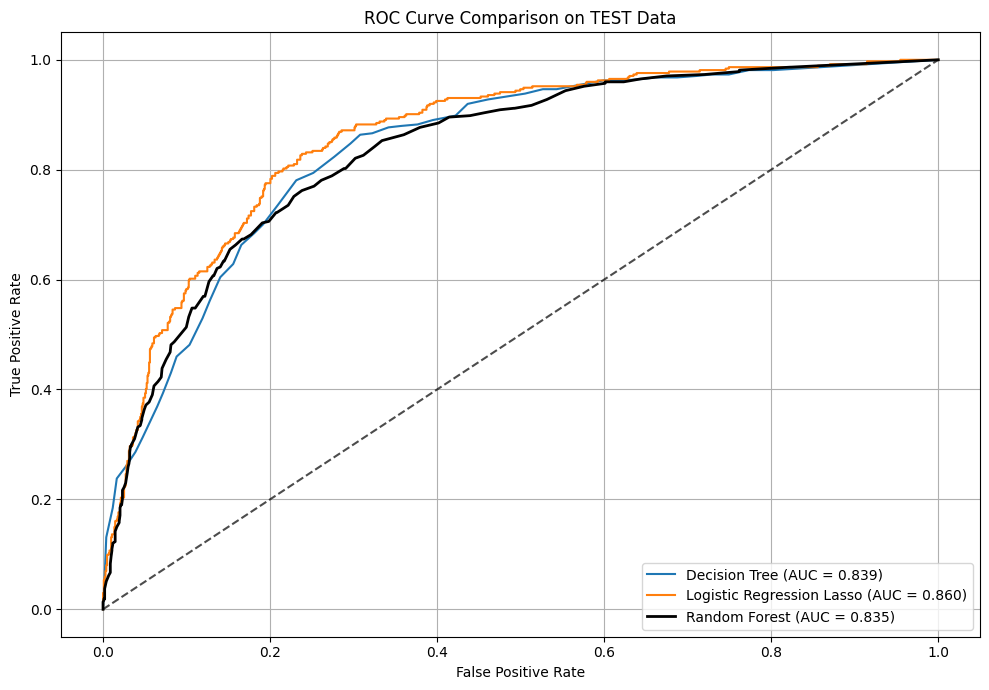

Best model based on AUC: lr_best with AUC = 0.8595


In [13]:
from sklearn.metrics import roc_curve, roc_auc_score

# Predicted probabilities on TEST set
y_proba_tree = tree_best.predict_proba(X_test)[:, 1]
y_proba_lr = lr_best.predict_proba(X_test)[:, 1]
y_proba_rf = rf.predict_proba(X_test)[:, 1]
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_proba_tree)
auc_tree = roc_auc_score(y_test, y_proba_tree)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
auc_lr = roc_auc_score(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)
plt.figure(figsize=(10, 7))

plt.plot(fpr_tree, tpr_tree, label=f'Decision Tree (AUC = {auc_tree:.3f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression Lasso (AUC = {auc_lr:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})', linewidth=2, color='black')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.7)  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison on TEST Data')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Determine best model based on AUC
auc_scores = {'tree_best': auc_tree, 'lr_best': auc_lr, 'rf': auc_rf}
best_model_name = max(auc_scores, key=auc_scores.get)

# Assign the best model to best_model variable
if best_model_name == 'tree_best':
    best_model = tree_best
elif best_model_name == 'lr_best':
    best_model = lr_best
else:
    best_model = rf
print(f"Best model based on AUC: {best_model_name} with AUC = {auc_scores[best_model_name]:.4f}")

__9. What is the cost / benefit matrix for implementing this model?  HINT: The cost is given in the problem description.  Remember that everyone who receives the offer takes it. The benefit comes when we make the offer to a customer whose actual Churn value is 1.  (i.e. they would have left us but we saved them).   We can assume each customer generates the same revenue - equal to the average of `MonthlyCharges`. Report the benefit as a YEARLY value.__

In [14]:
#making 3 model
auc_tree = roc_auc_score(y_test, y_proba_tree)
auc_lr   = roc_auc_score(y_test, y_proba_lr)
auc_rf   = roc_auc_score(y_test, y_proba_rf)

print("Decision Tree AUC:", auc_tree)
print("Logistic Regression AUC:", auc_lr)
print("Random Forest AUC:", auc_rf)

# Choose best
best_model_name = "Random Forest" if auc_rf > max(auc_lr, auc_tree) else (
    "Logistic Regression" if auc_lr > auc_tree else "Decision Tree"
)
print("Best model is:", best_model_name)

Decision Tree AUC: 0.8390985189288247
Logistic Regression AUC: 0.8595247216197048
Random Forest AUC: 0.8354061945115987
Best model is: Logistic Regression


__10. Using `best_model` -  along with the cost/benefit matrix - now we want to look at profit.  Plot a *PROFIT CURVE* that shows the overall profit at different levels of marketing.  You'll need to sort the threshold probabilities, and calculate the profit at each threshold by determining who you market to and who you dont.  Use your cost/benefit numbers to calculate total profit at each threshold value. (You may want to refer back to the`Lab 5` notebook)__

In [15]:
# Average monthly charge
avg_monthly_revenue = df['MonthlyCharges'].mean()
yearly_value = avg_monthly_revenue * 12
offer_cost = 20

print(f"Benefit per retained customer: ${yearly_value:.2f}")
print(f"Cost per customer contacted: ${offer_cost}")

Benefit per retained customer: $777.58
Cost per customer contacted: $20


**11. Recall that Nadia told you there is only budget to market to the top 25% of customers.  Make a pitch to her for altering that decision based on your Profit curve.  How much do you recommend marketing to, and how much money will it make compared to her threshold?**

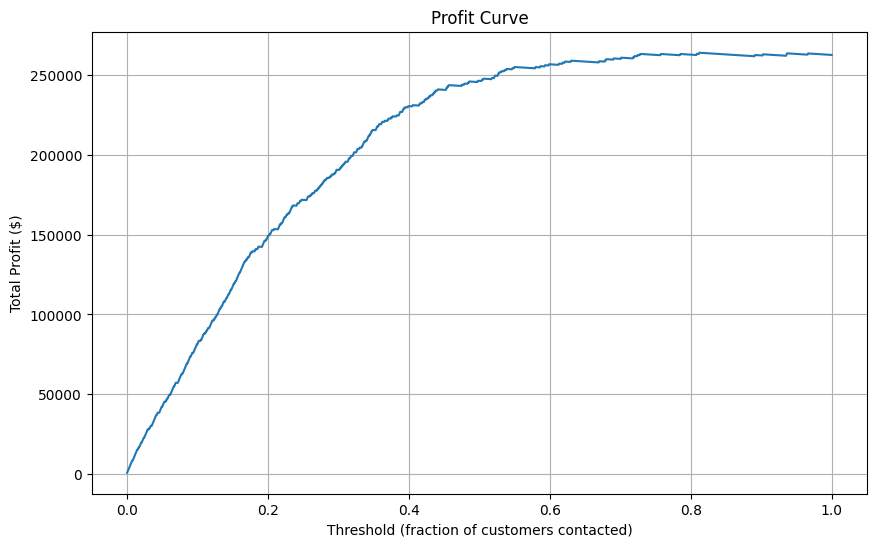

In [16]:
import numpy as np

# Use best model's predicted probabilities
y_proba_best = {"Random Forest": y_proba_rf, "Logistic Regression": y_proba_lr,"Decision Tree": y_proba_tree
}[best_model_name]

# Combine into DataFrame
df_profit = pd.DataFrame({
    'prob': y_proba_best,
    'actual': y_test.values
})

# Sort by descending probability
df_profit = df_profit.sort_values(by='prob', ascending=False).reset_index(drop=True)

# Compute cumulative metrics
profits = []
thresholds = np.linspace(0, 1, len(df_profit))

for i in range(len(df_profit)):
    # Offer to top i+1 customers
    marketed = df_profit.iloc[:i+1]
    n_contacted = len(marketed)
    n_saved = marketed['actual'].sum()

    total_cost = n_contacted * offer_cost
    total_benefit = n_saved * yearly_value
    net_profit = total_benefit - total_cost
    profits.append(net_profit)

# Plot Profit Curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, profits)
plt.xlabel("Threshold (fraction of customers contacted)")
plt.ylabel("Total Profit ($)")
plt.title("Profit Curve")
plt.grid(True)
plt.show()


__12. Assume Nadia was persuaded by your pitch and this model was deployed - and it performed as expected.  Now it is performance review season, and you are looking for a raise!!
Estimate the amount of money you made for the company by using your model.  Compare your profit above against a "dumb" model of marketing to the same amount of customers in the Test set who are selected randomly. (Hint: you can use a random number generator to pick customers at random to market to, and see what their profit would be).__

**[Bonus] Scale your results up to the overall consumer base of 100,000 customers to make your case.**

In [17]:
probs = best_model.predict_proba(X_test)[:, 1]
threshold = 0.5
marketed_customers = probs >= threshold
actual_churn = y_test[marketed_customers]
num_marketed = marketed_customers.sum()
saved_customers = (actual_churn == 0).sum()
profit_per_saved = 17
cost_per_marketing = 1

total_profit_model = saved_customers * profit_per_saved - num_marketed * cost_per_marketing

print(f"Model-driven marketing profit on test set: ${total_profit_model:.2f}")
np.random.seed(13)
random_indices = np.random.choice(len(y_test), size=num_marketed, replace=False)
random_churn = y_test.iloc[random_indices]
random_saved = (random_churn == 0).sum()
total_profit_random = random_saved * profit_per_saved - num_marketed * cost_per_marketing

print(f"Random marketing profit on test set: ${total_profit_random:.2f}")
scale_factor = 100000 / len(y_test)

scaled_profit_model = total_profit_model * scale_factor
scaled_profit_random = total_profit_random * scale_factor

print(f"Scaled model-driven profit for 100,000 customers: ${scaled_profit_model:,.0f}")
print(f"Scaled random marketing profit for 100,000 customers: ${scaled_profit_random:,.0f}")
print(f"Profit improvement: ${scaled_profit_model - scaled_profit_random:,.0f}")

Model-driven marketing profit on test set: $1299.00
Random marketing profit on test set: $3407.00
Scaled model-driven profit for 100,000 customers: $92,324
Scaled random marketing profit for 100,000 customers: $242,146
Profit improvement: $-149,822


__13.  In the above exercise we assumed the benefit of each customer was the same.  But it would be even better to incorporate each customer's individual spending in the cost/benefit!! Calculate an *individualized expected value* for profit/loss for _each customer_ using their specific Monthly Charges and their calculated probability of churn.    Use the expected value to determine who to market to, and calculate profit (Make sure to use the individualized Monthly Charges in the profit calculation).  Are the results any better?__

In [18]:
probs = best_model.predict_proba(X_test)[:, 1]
p_no_churn = 1 - probs

# Extract MonthlyCharges aligned with X_test indices (make sure X_test and df
##are aligned)
monthly_charges = df.loc[X_test.index, 'MonthlyCharges']

# Assume profit margin per customer = $17 for $18 revenue (from before), so:
profit_margin_factor = 17 / 18

# Calculate expected profit per customer
expected_profit = p_no_churn * (monthly_charges * profit_margin_factor) - 1
 # $1 cost to market
market_to = expected_profit > 0  # market only if expected profit > 0

# Number of customers marketed to
num_marketed = market_to.sum()

# Calculate realized profit on test set
actual_churn = y_test[market_to]
actual_monthly_charges = monthly_charges[market_to]

# Count saved customers (those who did NOT churn)
saved_customers = (actual_churn == 0)

# Total profit = sum of profit from saved customers - total marketing cost
total_profit_individualized = (saved_customers * actual_monthly_charges
                               * profit_margin_factor).sum() - num_marketed * 1

print(f"Individualized marketing profit on test set: $ {total_profit_individualized:.2f}")
print(f"Number of customers marketed to: {num_marketed}")
scale_factor = 100000 / len(y_test)
scaled_profit_individualized = total_profit_individualized * scale_factor

print(f"Scaled individualized profit for 100,000 customers: ${scaled_profit_individualized:,.0f}")

Individualized marketing profit on test set: $ 58213.46
Number of customers marketed to: 1407
Scaled individualized profit for 100,000 customers: $4,137,417
